### Importing SLS functions
This Python file contains all of the necessary functions to perfrom the SLS analysis. \
In this file, the molecular weight, the radius of gyration and the second virial constant is determined. \
Besides, plots are made that show different characteristics of the measured solution. \
In addition, the form factor is determined, where it is shown how to add fits into the plot.

In [10]:
from SLS_functions import *

The following code calls the function, in which everything is calculated and determined.\
The class takes multiple arguments:
1. measurement_folder \
this is the main directory folder that contains every measurement with different concentrations.
2. Concentrations \
in order to perform the analysis, the concentrations need to be known in order to perform the extrapolation.
3. dn_dc \
This should be same for every measurement.
4. x_max \
this determines the Guinier regime, should stay around the 0.4.

In [ ]:
measurement = SLS_analysis(
    measurement_folder = r'temporary name',
    concentrations = [0.000549],
        dn_dc = 0.1,
        x_max=0.4
)

# The Zimm plot
This is the gold standard for SLS measurements.\
Linearize both the angle and concentration simultaneously to get the
- molecular weight (Mw)
- radius of gyration (Rg)
- second virial constant (A2)   
all from one plot. 

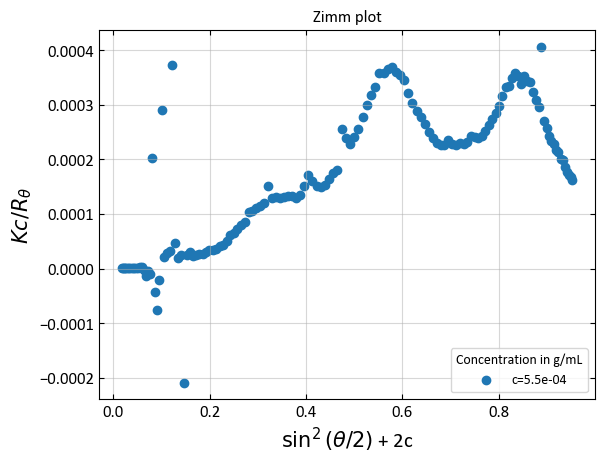

In [12]:
measurement.plot_zimm()

# The Berry plot
This takes the square root to improve linearity.\
Better behaved for: high Mw polymers, noisy data, large Rg.\
This makes for straighter lines than a Zimm plot, less curvature at high q's.

c:\Users\tsboe\OneDrive\Python - programming\SLS_functions.py:200: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(x + 2*concentration, np.sqrt(y), label=f"c={c:.1e}")


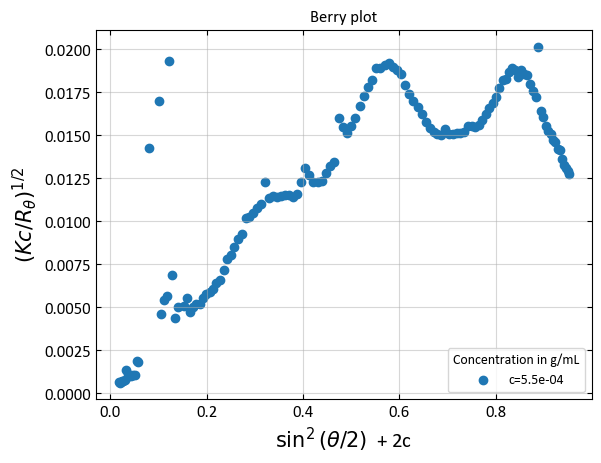

In [13]:
measurement.plot_berry()

# The Guinier plot
Only small-angle limited, due to the neglected concentration effects.\
This can only be used for Rg only.\
Makes a straight line at small q, breaks down at larger q.

c:\Users\tsboe\OneDrive\Python - programming\SLS_functions.py:212: RuntimeWarning: invalid value encountered in log
  plt.scatter(q**2 + 2*concentration, np.log(1 / y), label=f"c={c:.1e}")


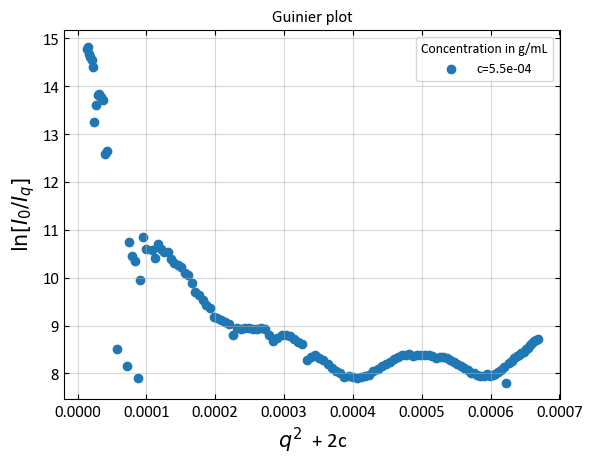

In [14]:
measurement.plot_guinier()

By tuning the max qRg value, the plot can see what the Guinier regime is.

min(q*Rg): 0.054801400914645526
max(q*Rg): 0.40981543504932033


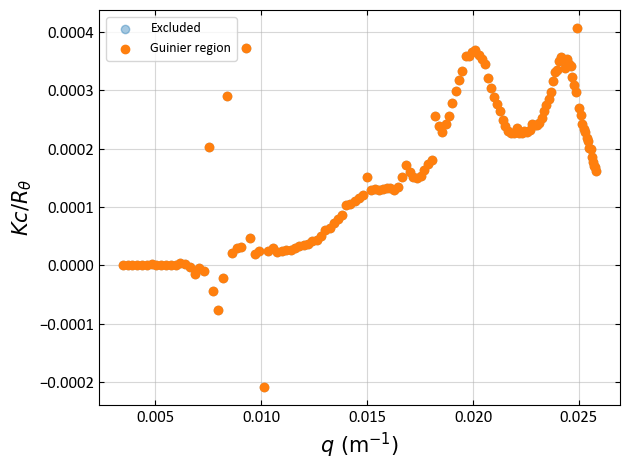

In [15]:
measurement.plot_guinier_selection(qRg_max=0.1) 

By calling the following object, the characteristics of the solution can be found.\
This is determined with the Zimm plot.

In [16]:
measurement.results

{'Mw': np.float64(262602.8560525965),
 'Rg': np.float64(15.869382209336159),
 'A2': np.float64(0.003468152730995978)}

# The Kratochvíl plot
This is used to determined the second virial coefficient more cleanly and robust then the Zimm plot.\
The limitation with this is that this only works on small angles.\
Can also be used to check wether the second virial constant is correct, the line shown should be linear.

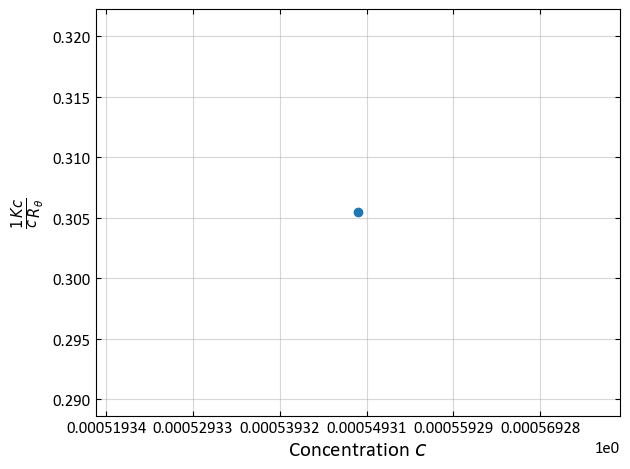

In [17]:
measurement.plot_kratochvil()

# The Form factor
This plot plots the determined form factor over the scattering vector.\
This plot in itself doesn't say much, but can be used to fit a form function with it.

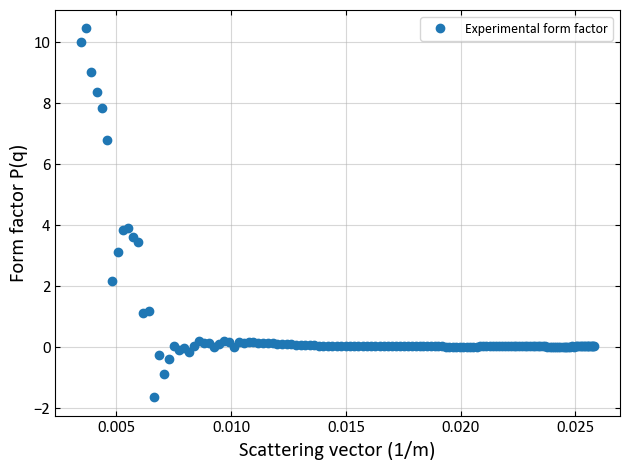

In [18]:
measurement.plot_form_factor()

In [19]:
def sphere_form_factor(q, A, R, B):
    qR = q * R

    # avoid divide-by-zero at q=0
    qR = np.where(qR == 0, 1e-16, qR)

    P = 3 * (np.sin(qR) - qR * np.cos(qR)) / (qR**3)
    return A * P**2 + B

In [20]:
parameters, _= curve_fit(sphere_form_factor, measurement.determine_form_factor(normalized=False)[0], measurement.determine_form_factor(normalized=False)[1])

print(f'Fit Radius R = {parameters[0]}')
print(f'Fit Intensity Scale A = {parameters[1]}')
print(f'Fit Flat background B = {parameters[2]}')

Fit Radius R = 23.57696828887112
Fit Intensity Scale A = 545.2426298737864
Fit Flat background B = -0.012395381986309736


In [21]:
fit_data = sphere_form_factor(q = measurement.determine_form_factor(normalized=False)[0],
                                       A = parameters[0],
                                       R = parameters[1],
                                       B = parameters[2])

This plot shown the form factor with a fit of a solid sphere function, since the data is from the Polybeads.

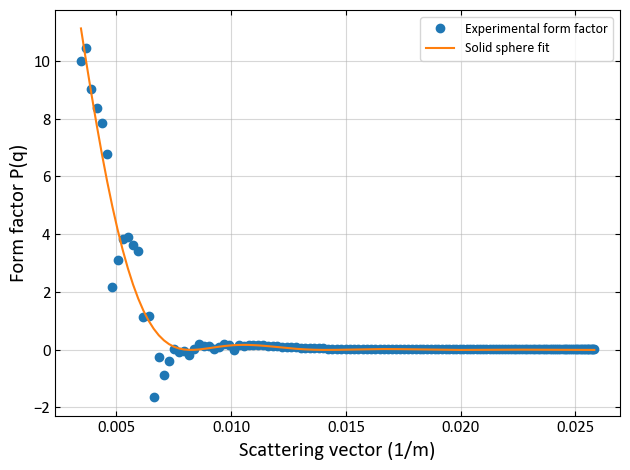

In [22]:
measurement.plot_form_factor(fit_output=True, fit_data=fit_data, fit_label_name='Solid sphere fit')

With this, the option to determine the polydisperisty is given.\
The polydisperisty is a characteristic of the form factor.

In [23]:
def polydisperse_sphere_form_factor(q, A, R0, sigma, B, n_points=60):
    """
    Log-normal polydisperse sphere model for SLS

    Parameters
    ----------
    q : array
        scattering vector
    A : float
        intensity scale
    R0 : float
        median radius (m)
    sigma : float
        log-normal width (0–0.4 typical)
    B : float
        background
    n_points : int
        integration resolution

    Returns
    -------
    I(q)
    """

    # ---- integration grid in R ----
    R = np.logspace(
        np.log10(R0/5),
        np.log10(R0*5),
        n_points
    )

    # ---- log-normal distribution ----
    f = (
        1/(R*sigma*np.sqrt(2*np.pi))
        * np.exp(-(np.log(R/R0))**2/(2*sigma**2))
    )

    # ---- volume weighting ----
    V = (4/3)*np.pi*R**3
    weight = f * V**2

    P_avg = np.zeros_like(q)

    for Ri, wi in zip(R, weight):
        qR = q * Ri

        P = np.ones_like(qR)
        mask = qR != 0
        qr = qR[mask]
        P[mask] = 3*(np.sin(qr)-qr*np.cos(qr))/(qr**3)

        P_avg += wi * P**2

    P_avg /= np.sum(weight)

    return A * P_avg + B


In [24]:
q, Pq = measurement.determine_form_factor(normalized=False)

p0 = [
    1.0,        # A
    50e-9,      # R0 (50 nm)
    0.15,       # sigma
    0.0         # background
]

bounds = (
    [0,  1e-9,  0.001, -np.inf],
    [np.inf, 1e-5, 1.0, np.inf]
)

params, cov = curve_fit(
    polydisperse_sphere_form_factor,
    q,
    Pq,
    p0=p0,
    bounds=bounds
)

A, R0, sigma, B = params

print(f'Fit Median Particle Radius = {R0}')
print(f'Poludispersity Index = {sigma}')

Fit Median Particle Radius = 5e-08
Poludispersity Index = 0.15


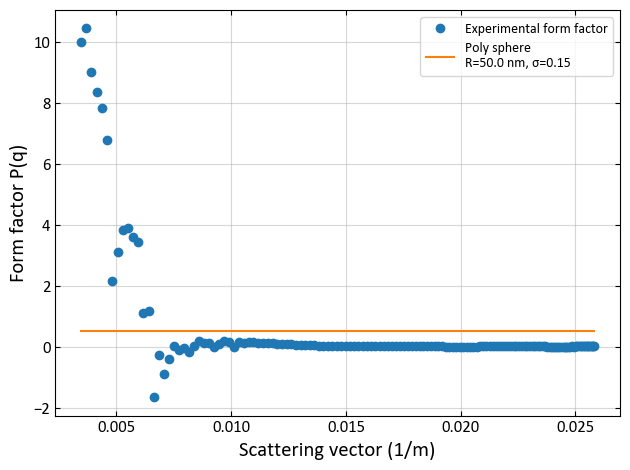

In [25]:
fit = polydisperse_sphere_form_factor(q, *params)

measurement.plot_form_factor(
    fit_data=fit,
    fit_output=True,
    fit_label_name=f"Poly sphere\nR={R0*1e9:.1f} nm, σ={sigma:.2f}"
)
